In [4]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
av = pd.read_csv('avocado.csv', index_col=0)

In [6]:
av.head()
# we need to find average price per day per region, since we have the same day for several cities in the same state
# how do we do that???? does it affect stationarity, how do we deal with it?

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [7]:
av.rename(columns={'4046':'small', '4225':'medium', '4770':'large'}, inplace=True)

In [8]:
av.drop(columns=['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'], inplace=True)

In [9]:
av.shape

(18249, 9)

# creating date time object in date column

In [10]:
av['Date'] = pd.to_datetime(av['Date'], format='%Y-%m-%d')

In [11]:
av.head()

,Date,AveragePrice,Total Volume,small,medium,large,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,conventional,2015,Albany


In [12]:
av.set_index('Date', inplace=True)

# simple EDA

In [10]:
# sns.pairplot(av)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1195854d0> (for post_execute):


KeyboardInterrupt: 

In [11]:
# Function to plot each feature vs target variable
def plot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, x_vars=row, y_vars='AveragePrice', kind='reg', height=3)
    return plt.show()

features = av.drop(['type', 'year', 'region', 'Date'], axis=1).keys()
plot_features(av, features)

KeyError: "['Date'] not found in axis"

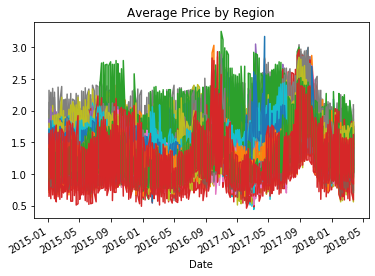

In [367]:
av.groupby('region')['AveragePrice'].plot()
plt.title('Average Price by Region')
plt.show()

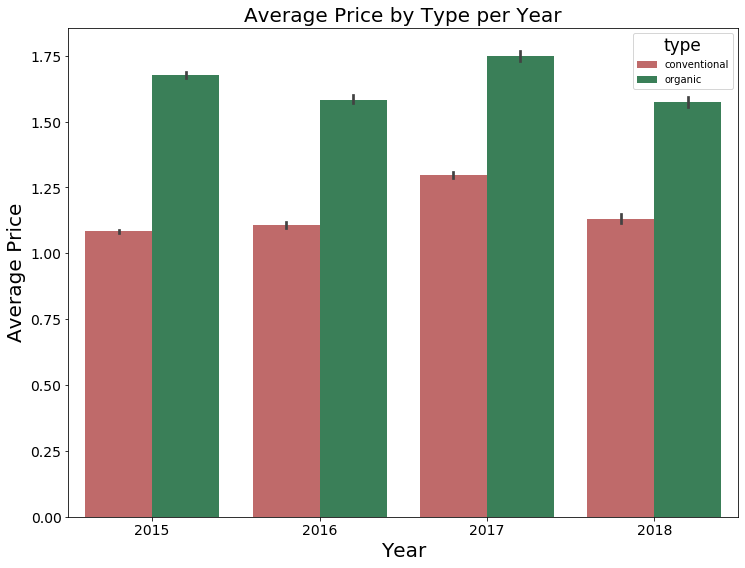

In [78]:
flatui = ['indianred','seagreen']

fig, ax = plt.subplots(figsize=(12,9))
ax = sns.barplot(x='year', y='AveragePrice', hue='type', data=avocado, palette=flatui)
ax.set_title('Average Price by Type per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Average Price')

plt.rc('axes', titlesize=20, )     # fontsize of the axes title
plt.rc('axes', labelsize= 20)  # fontsize of the x and y labels
plt.rc('xtick', labelsize = 14)    # fontsize of the tick labels
plt.rc('ytick', labelsize = 14)

# plt.savefig('Images/avg_price_type_year' , dpi=200)

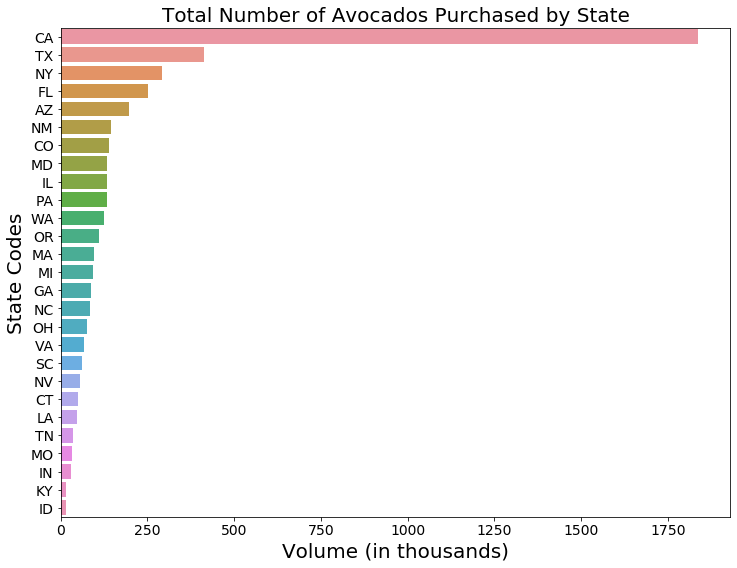

In [80]:
graph2 = avocado.groupby('region')['Total Volume'].sum().sort_values(ascending = False)
fig,ax = plt.subplots(figsize = (12,9))
ax = sns.barplot((graph2.values)/1000000, graph2.index)
ax.set_xlabel('Volume (in thousands)')
ax.set_ylabel('State Codes')
ax.set_title('Total Number of Avocados Purchased by State')

# plt.savefig('Images/total_sales_state' , dpi=200)

----

---

# removing regions and combining multiple cities into a single state

In [15]:
av['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [368]:
 stat = {'Albany':'NY', 'Atlanta':'GA', 'BaltimoreWashington':'MD', 'Boise':'ID','Boston':'MA',
         'BuffaloRochester':'NY', 'California':'CA', 'Charlotte':'NC', 'Chicago':'IL', 'Detroit':'MI',
         'GrandRapids':'MI', 'GreatLakes':'greatlakes', 'HarrisburgScranton':'PA', 'HartfordSpringfield': 'CT',
         'Houston':'TX', 'Indianapolis':'IN', 'Jacksonville':'FL', 'LasVegas':'NV', 'LosAngeles':'CA',
         'Louisville':'KY', 'MiamiFtLauderdale':'FL', 'Midsouth':'midsouth', 'Nashville':'TN',
         'NewOrleansMobile':'LA', 'NewYork':'NY', 'Northeast':'northeast',
         'NorthernNewEngland':'northernnewengland', 'Orlando':'FL', 'Philadelphia':'PA', 'PhoenixTucson':'AZ',
         'Pittsburgh':'PA', 'Plains':'plains', 'Portland':'OR', 'RaleighGreensboro':'NC', 
         'RichmondNorfolk':'VA', 'Roanoke':'VA', 'Sacramento':'CA', 'SanDiego':'CA', 'SanFrancisco':'CA',
         'Seattle':'WA', 'SouthCarolina':'SC', 'SouthCentral':'southcentral', 'Southeast':'southeast',
         'Spokane':'WA', 'StLouis':'MO', 'Syracuse':'NY', 'Tampa':'FL', 'TotalUS':'USA', 'West':'west', 
         'WestTexNewMexico':'NM', 'CincinnatiDayton':'OH', 'Columbus':'OH', 'DallasFtWorth':'TX', 'Denver':'CO'}

In [17]:
#getting rid of not cities
cities = list(set(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico']) - set(['Northeast', 'Midsouth', 'Southeast', 'SouthCentral', 'West', 'GreatLakes', 'TotalUS', 'NorthernNewEngland', 'Plains']))

In [369]:
cities[:5]

['RichmondNorfolk',
 'HarrisburgScranton',
 'Sacramento',
 'Seattle',
 'Louisville']

In [19]:
avocado = av[av['region'].isin(cities)].copy()

In [20]:
avocado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15207 entries, 2015-12-27 to 2018-01-07
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AveragePrice  15207 non-null  float64
 1   Total Volume  15207 non-null  float64
 2   small         15207 non-null  float64
 3   medium        15207 non-null  float64
 4   large         15207 non-null  float64
 5   type          15207 non-null  object 
 6   year          15207 non-null  int64  
 7   region        15207 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 1.0+ MB


In [370]:
avocado.head()

,AveragePrice,Total Volume,small,medium,large,type,year,region
Date,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,conventional,2015,NY
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,conventional,2015,NY
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,conventional,2015,NY
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,conventional,2015,NY
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,conventional,2015,NY


In [23]:
avocado.shape

(15207, 8)

In [24]:
avocado.replace({'region':stat}, inplace=True)

# creating df for different types of avocados

In [27]:
conventional = avocado[avocado['type'] == 'conventional']
conventional.head()

,AveragePrice,Total Volume,small,medium,large,type,year,region
Date,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,conventional,2015,NY
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,conventional,2015,NY
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,conventional,2015,NY
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,conventional,2015,NY
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,conventional,2015,NY


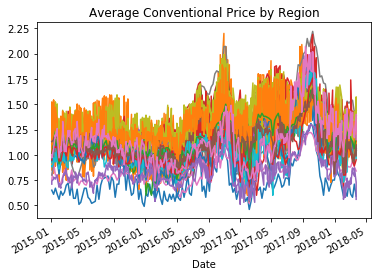

In [373]:
conventional.groupby('region')['AveragePrice'].plot()
plt.title('Average Conventional Price by Region')
plt.show()

In [28]:
organic = avocado[avocado['type'] == 'organic']

In [29]:
organic.head()

,AveragePrice,Total Volume,small,medium,large,type,year,region
Date,,,,,,,,
2015-12-27,1.83,989.55,8.16,88.59,0.0,organic,2015,NY
2015-12-20,1.89,1163.03,30.24,172.14,0.0,organic,2015,NY
2015-12-13,1.85,995.96,10.44,178.70,0.0,organic,2015,NY
2015-12-06,1.84,1158.42,90.29,104.18,0.0,organic,2015,NY
2015-11-29,1.94,831.69,0.00,94.73,0.0,organic,2015,NY


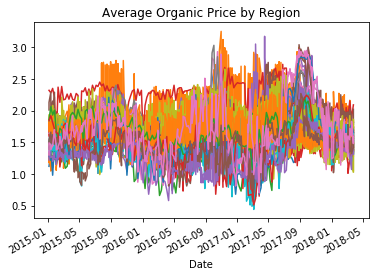

In [372]:
organic.groupby('region')['AveragePrice'].plot()
plt.title('Average Organic Price by Region')
plt.show()

In [473]:
# organic.to_csv('organic.csv')
# conventional.to_csv('conventional.csv')

---

# dickey fuller test

In [379]:
test_conventional = adfuller(np.log(conventional['AveragePrice']).diff(periods = 1)[1:])
dfoutput = pd.Series(test_conventional[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -20.385726
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7567.000000
dtype: float64


In [380]:
test_organic = adfuller(np.log(organic['AveragePrice']).diff(periods = 1)[1:])
dfoutput = pd.Series(test_organic[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -22.237105
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    7564.000000
dtype: float64


In [381]:
#conventional prices by date
conventional_by_date = conventional.groupby(['Date'])['AveragePrice'].mean()
conventional_differenced = (np.log(conventional_by_date)).diff(periods = 1)[1:]
#organic prices by date
organic_by_date = organic.groupby(['Date'])['AveragePrice'].mean()
organic_differenced = (np.log(organic_by_date)).diff(periods = 1)[1:]

---

# ARIMA -> SARIMA -> Prophet

1. Used logged transformation of mean organic and conventional data (grouped by dates) for ARIMA and SARIMA models
2. Input original grouped mean organic and conventional data for Prophet

**Grouping organic data and transforming**

In [382]:
organic_by_date = organic.groupby(['Date'])['AveragePrice'].mean()
log_organic_final = (np.log(organic_by_date))

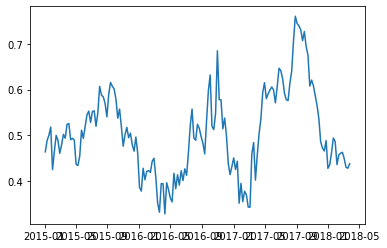

In [383]:
sns.lineplot(data = log_organic_final)

In [384]:
tss = TimeSeriesSplit(n_splits = 2)

In [385]:
X_org = log_organic_final.index
y_org = log_organic_final.values

for train_index, test_index in tss.split(X_org):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_org_train, X_org_test = X_org[train_index], X_org[test_index]
    y_org_train, y_org_test = y_org[train_index], y_org[test_index]

In [387]:
org_train = pd.DataFrame(y_org_train,index = X_org_train, columns = ['AveragePrice'])
org_test = pd.DataFrame(y_org_test, index = X_org_test, columns = ['AveragePrice'])
org_train.head()

,AveragePrice
Date,
2015-01-04,0.463874
2015-01-11,0.488716
2015-01-18,0.500371
2015-01-25,0.518132
2015-02-01,0.425122


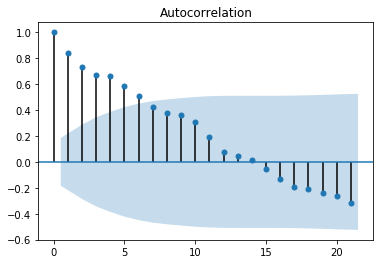

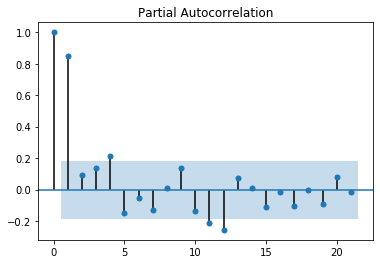

In [82]:
plot_acf(org_train)
plot_pacf(org_train)
plt.show()

**Running ARIMA and SARIMA model on log organic data**

In [316]:
#After running for loops for multiple possible ACF/PACF, we obtained the best order of (2,1,2)
log_org_arima = ARIMA(org_train, order=(2,1,2)).fit()
log_org_arima.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.AveragePrice   No. Observations:                  112
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 210.740
Method:                       css-mle   S.D. of innovations              0.037
Date:                Wed, 17 Jun 2020   AIC                           -409.481
Time:                        14:35:44   BIC                           -393.170
Sample:                    01-11-2015   HQIC                          -402.863
                         - 02-26-2017                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0010      0.003     -0.348      0.728      -0.007       0.005
ar.L1.D.AveragePrice     0.5929      0.065      9.190      0.000       0.466       0.719
ar.L2.D.AveragePrice    -0.9223      0.083    -11.138      0.000      -1.085      -0.760
ma.L1.D.AveragePrice    -0.7132      0.075     -9.560      0.000      -0.859      -0.567
ma.L2.D.AveragePrice     0.8652      0.119      7.275      0.000       0.632       1.098
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3214           -0.9904j            1.0413           -0.2001
AR.2            0.3214           +0.9904j            1.0413            0.2001
MA.1            0.4122           -0.9929j            1.0751           -0.1874
MA.2            0.4122           +0.9929j            1.0751            0.1874
-----------------------------------------------------------------------------
"""

In [389]:
preds_org_arima = np.exp(log_org_arima.forecast(56)[0])

error_org_arima = np.sqrt(((org_test.values - preds_org_arima)**2).mean())
print('RMSE in cents: ',error_org_arima) #error in cents

RMSE in cents:  0.8361977344930643


**SARIMAX**

In [390]:
log_org_sarima = SARIMAX(org_train, order = (0,1,0), seasonal_order = (2,1,2,4)).fit()
log_org_sarima.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                           AveragePrice   No. Observations:                  113
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 4)   Log Likelihood                 192.287
Date:                                Wed, 17 Jun 2020   AIC                           -374.575
Time:                                        15:16:36   BIC                           -361.164
Sample:                                    01-04-2015   HQIC                          -369.137
                                         - 02-26-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4       -0.5396      2.461     -0.219      0.826      -5.363       4.284
ar.S.L8        0.2426      0.670      0.362      0.717      -1.070       1.555
ma.S.L4       -0.1764      2.583     -0.068      0.946      -5.240       4.887
ma.S.L8       -0.8141      2.641     -0.308      0.758      -5.990       4.362
sigma2         0.0015      0.001      1.120      0.263      -0.001       0.004
===================================================================================
Ljung-Box (Q):                       52.53   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.09   Prob(JB):                         0.78
Heteroskedasticity (H):               2.17   Skew:                             0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [391]:
preds_org_sarima = np.exp(log_org_sarima.forecast(56))

error_org_sarima = np.sqrt(((org_test.values - preds_org_sarima.values)**2).mean())
print('RMSE in cents: ',error_org_sarima) # error in cents

RMSE in cents:  0.7836138747325437


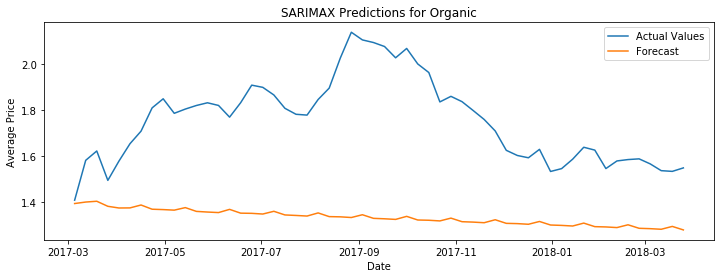

In [443]:
fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x = org_test.index, y = np.exp(org_test['AveragePrice']), label = 'Actual Values') #org_test was logged so we reverse it back
ax2 = sns.lineplot(x=X_org_test, y = preds_org_sarima, label='Forecast')

plt.ylabel('Average Price')
plt.title('SARIMAX Predictions for Organic')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
# plt.savefig('Images/sarima_org.png', dpi=300)

## Prophet (ORGANIC)
Modeling organic data using untransformed data. Results are better than ARIMA and SARIMA

In [345]:
prophet_org_set = np.exp(org_train['AveragePrice']).copy()

In [346]:
prophet_org_set = pd.DataFrame(prophet_org_set).reset_index()
prophet_org_set.rename(columns = {'Date': 'ds', 'AveragePrice': 'y'}, inplace = True)

In [347]:
prophet_org_set.head()

,ds,y
0,2015-01-04,1.590222
1,2015-01-11,1.630222
2,2015-01-18,1.649333
3,2015-01-25,1.678889
4,2015-02-01,1.529778


In [348]:
Model_org = Prophet(interval_width=0.95).fit(prophet_org_set)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [392]:
future_org = Model_org.make_future_dataframe(periods=56,freq = 'W')
future_org.tail()

,ds
164,2018-02-25
165,2018-03-04
166,2018-03-11
167,2018-03-18
168,2018-03-25


In [393]:
forecast_org = Model_org.predict(future_org)
forecast_org.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
164,2018-02-25,1.624387,1.409914,1.651631,1.584293,1.667820,-0.095168,-0.095168,-0.095168,-0.095168,-0.095168,-0.095168,0.0,0.0,0.0,1.529220
165,2018-03-04,1.624989,1.390598,1.629968,1.583715,1.670407,-0.108357,-0.108357,-0.108357,-0.108357,-0.108357,-0.108357,0.0,0.0,0.0,1.516632
166,2018-03-11,1.625590,1.389763,1.617229,1.583002,1.672288,-0.121285,-0.121285,-0.121285,-0.121285,-0.121285,-0.121285,0.0,0.0,0.0,1.504305
167,2018-03-18,1.626191,1.391358,1.628043,1.581351,1.673791,-0.116400,-0.116400,-0.116400,-0.116400,-0.116400,-0.116400,0.0,0.0,0.0,1.509791
168,2018-03-25,1.626793,1.422609,1.643478,1.580007,1.676035,-0.095594,-0.095594,-0.095594,-0.095594,-0.095594,-0.095594,0.0,0.0,0.0,1.531199


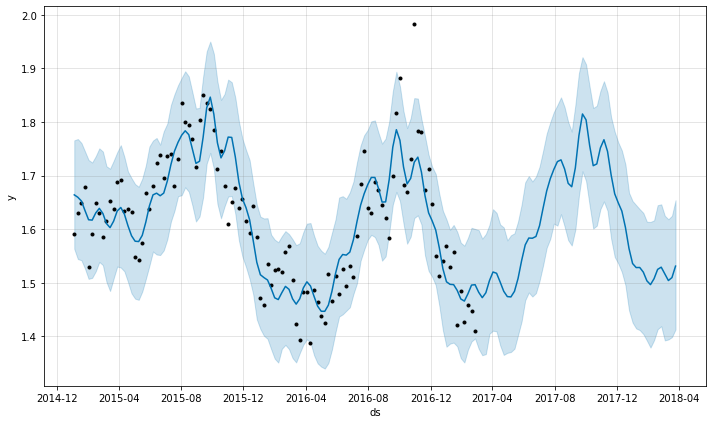

In [354]:
fig1_org = Model_org.plot(forecast_org)

In [394]:
preds_org = forecast_org.iloc[113:][['ds','yhat']].set_index('ds')
preds_org.head()

,yhat
ds,
2017-03-05,1.482386
2017-03-12,1.472346
2017-03-19,1.481484
2017-03-26,1.503972
2017-04-02,1.520231


In [395]:
preds_org_df = pd.concat([np.exp(org_test),preds_org],axis = 1)
preds_org_df.head()

,AveragePrice,yhat
2017-03-05,1.408889,1.482386
2017-03-12,1.582222,1.472346
2017-03-19,1.622889,1.481484
2017-03-26,1.495111,1.503972
2017-04-02,1.578667,1.520231


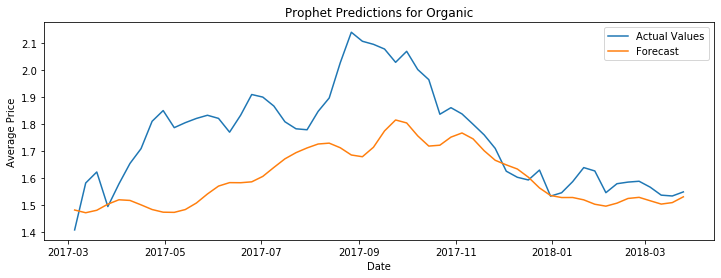

In [446]:
fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x=preds_org_df.index, y=preds_org_df['AveragePrice'], label='Actual Values')
ax2 = sns.lineplot(x=preds_org_df.index, y=preds_org_df['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Organic')
# plt.savefig('Images/prophet_org.png', dpi=300)

In [397]:
print('RMSE in cents: ',np.sqrt(sum((preds_org_df['AveragePrice'] - preds_org_df['yhat'])**2)/len(preds_org_df)))

RMSE in cents:  0.20096730420623143


---

**Grouping conventional data and transforming**

In [285]:
conventional_by_date = conventional.groupby(['Date'])['AveragePrice'].mean()
log_conventional_final = (np.log(conventional_by_date))

In [286]:
#train test split on con
tss_con = TimeSeriesSplit(n_splits = 2)

X_con = log_conventional_final.index
y_con = log_conventional_final.values

for train_index, test_index in tss_con.split(X_org):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_con_train, X_con_test = X_con[train_index], X_con[test_index]
    y_con_train, y_con_test = y_con[train_index], y_con[test_index]
    
con_train = pd.DataFrame(y_con_train,index = X_con_train, columns = ['AveragePrice'])
con_test = pd.DataFrame(y_con_test, index = X_con_test, columns = ['AveragePrice'])

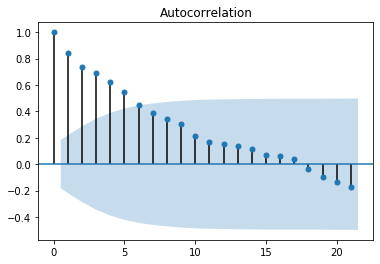

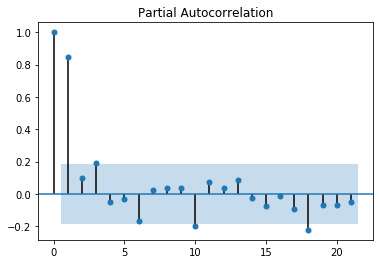

In [287]:
plot_acf(con_train)
plot_pacf(con_train)
plt.show()

**ARIMA model**

In [398]:
#best order from for loop (2,1,2)
log_con_arima = ARIMA(con_train, order=(2,1,2)).fit()
log_con_arima.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.AveragePrice   No. Observations:                  112
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 168.756
Method:                       css-mle   S.D. of innovations              0.052
Date:                Wed, 17 Jun 2020   AIC                           -325.512
Time:                        15:20:27   BIC                           -309.201
Sample:                    01-11-2015   HQIC                          -318.894
                         - 02-26-2017                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0004      0.005      0.082      0.935      -0.009       0.010
ar.L1.D.AveragePrice     0.2625      0.025     10.328      0.000       0.213       0.312
ar.L2.D.AveragePrice    -0.9782      0.024    -41.076      0.000      -1.025      -0.931
ma.L1.D.AveragePrice    -0.3582      0.042     -8.433      0.000      -0.441      -0.275
ma.L2.D.AveragePrice     0.9999      0.066     15.121      0.000       0.870       1.129
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.1342           -1.0022j            1.0111           -0.2288
AR.2            0.1342           +1.0022j            1.0111            0.2288
MA.1            0.1791           -0.9839j            1.0001           -0.2213
MA.2            0.1791           +0.9839j            1.0001            0.2213
-----------------------------------------------------------------------------
"""

In [399]:
preds_con_arima = np.exp(log_con_arima.forecast(56)[0])

error_con_arima = np.sqrt(((con_test.values - preds_con_arima)**2).mean())
print('RMSE in cents: ',error_con_arima)

RMSE in cents:  0.8599467431413219


**SARIMA model**

In [298]:
log_con_sarima = SARIMAX(con_train, seasonal_order = (1,1,1,4)).fit()
log_con_sarima.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        AveragePrice   No. Observations:                  113
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 4)   Log Likelihood                 156.678
Date:                             Wed, 17 Jun 2020   AIC                           -305.355
Time:                                     14:26:45   BIC                           -294.590
Sample:                                 01-04-2015   HQIC                          -300.990
                                      - 02-26-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8512      0.055     15.447      0.000       0.743       0.959
ar.S.L4        0.0018      0.126      0.014      0.989      -0.246       0.249
ma.S.L4       -0.9223      0.081    -11.395      0.000      -1.081      -0.764
sigma2         0.0031      0.000     10.099      0.000       0.002       0.004
===================================================================================
Ljung-Box (Q):                       36.97   Jarque-Bera (JB):                54.21
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                            -0.99
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [400]:
preds_con_sarima = np.exp(log_con_sarima.forecast(56))

error_con_sarima = np.sqrt(((con_test.values - preds_con_sarima.values)**2).mean())
print('RMSE in cents: ',error_con_sarima) # error in cents

RMSE in cents:  0.8489399037968287


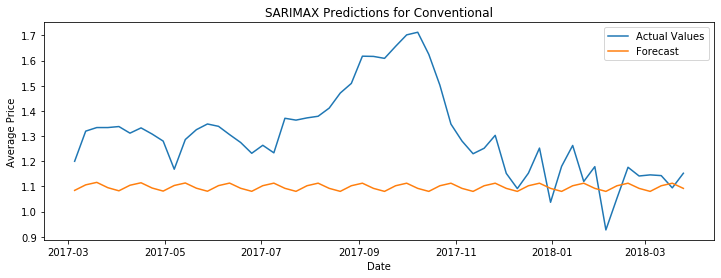

In [445]:
fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x = con_test.index, y = np.exp(con_test['AveragePrice']), label = 'Actual Values') #org_test was logged so we reverse it back
ax2 = sns.lineplot(x=X_con_test, y = preds_con_sarima, label='Forecast')

plt.ylabel('Average Price')
plt.title('SARIMAX Predictions for Conventional')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
# plt.savefig('Images/sarima_con.png', dpi=300)

# Prophet on conventional

In [335]:
prophet_con_set = np.exp(con_train['AveragePrice']).copy()

prophet_con_set = pd.DataFrame(prophet_con_set).reset_index()
prophet_con_set.rename(columns = {'Date': 'ds', 'AveragePrice': 'y'}, inplace = True)

prophet_con_set.head()

,ds,y
0,2015-01-04,1.014667
1,2015-01-11,1.119333
2,2015-01-18,1.144667
3,2015-01-25,1.124444
4,2015-02-01,0.966000


In [336]:
Model_con = Prophet(interval_width=0.95).fit(prophet_con_set)

future_con = Model_con.make_future_dataframe(periods=56,freq = 'W')

future_con.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds
164,2018-02-25
165,2018-03-04
166,2018-03-11
167,2018-03-18
168,2018-03-25


In [337]:
forecast_con = Model_con.predict(future_con)

forecast_con.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
164,2018-02-25,1.340901,1.143957,1.412024,1.244182,1.438227,-0.062852,-0.062852,-0.062852,-0.062852,-0.062852,-0.062852,0.0,0.0,0.0,1.278049
165,2018-03-04,1.343759,1.153792,1.456689,1.245280,1.443884,-0.040086,-0.040086,-0.040086,-0.040086,-0.040086,-0.040086,0.0,0.0,0.0,1.303673
166,2018-03-11,1.346616,1.142098,1.445963,1.246689,1.448859,-0.051974,-0.051974,-0.051974,-0.051974,-0.051974,-0.051974,0.0,0.0,0.0,1.294643
167,2018-03-18,1.349474,1.124239,1.433099,1.246464,1.453350,-0.067901,-0.067901,-0.067901,-0.067901,-0.067901,-0.067901,0.0,0.0,0.0,1.281573
168,2018-03-25,1.352332,1.123090,1.454835,1.246464,1.459478,-0.061780,-0.061780,-0.061780,-0.061780,-0.061780,-0.061780,0.0,0.0,0.0,1.290552


,yhat
ds,
2017-03-05,1.154878
2017-03-12,1.142423
2017-03-19,1.132164
2017-03-26,1.145324
2017-04-02,1.168634


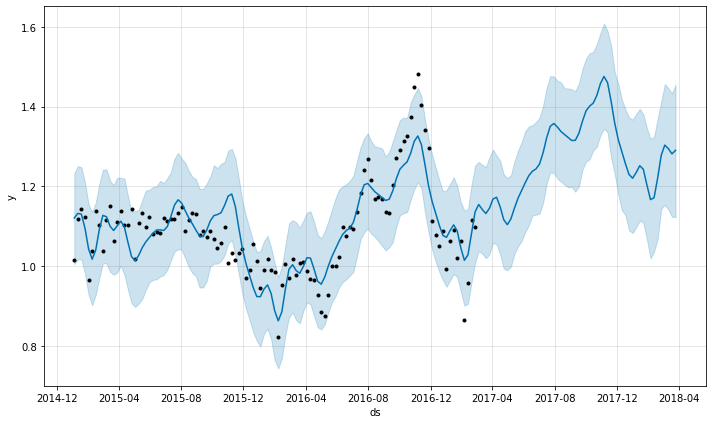

In [338]:
fig1_con = Model_con.plot(forecast_con)

preds_con = forecast_con.iloc[113:][['ds','yhat']].set_index('ds')

preds_con.head()


In [342]:
preds_con_df = pd.concat([np.exp(con_test),preds_con],axis = 1)

preds_con_df.head()

,AveragePrice,yhat
2017-03-05,1.199778,1.154878
2017-03-12,1.319556,1.142423
2017-03-19,1.333778,1.132164
2017-03-26,1.333778,1.145324
2017-04-02,1.337778,1.168634


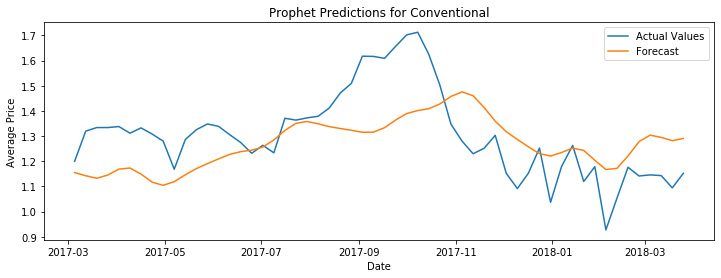

In [448]:
fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x=preds_con_df.index, y=preds_con_df['AveragePrice'], label='Actual Values')
ax2 = sns.lineplot(x=preds_con_df.index, y=preds_con_df['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Conventional')
# plt.savefig('Images/prophet_con.png', dpi=300)

In [401]:
print('RMSE in cents: ',np.sqrt(sum((preds_con_df['AveragePrice'] - preds_con_df['yhat'])**2)/len(preds_con_df)))

RMSE in cents:  0.16185518649497696


# End of Analysis

---

---

# Obtaining best order parameters for ARIMA

**conventional differenced acf/pacf**

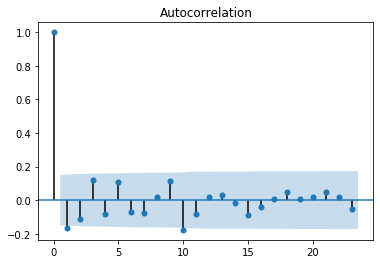

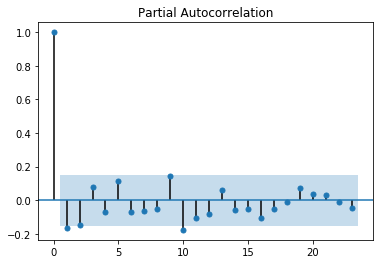

In [154]:
plot_acf(conventional_differenced)
plot_pacf(conventional_differenced)
plt.show()

**organic differenced acf/pacf**

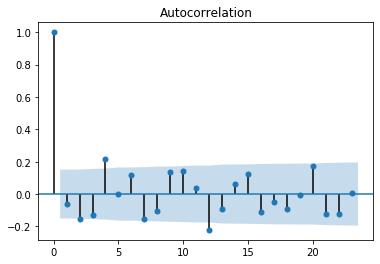

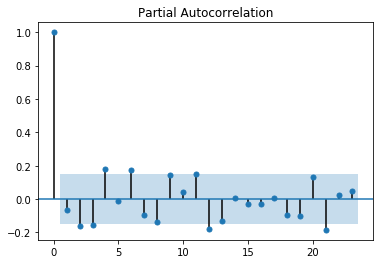

In [156]:
plot_acf(organic_differenced)
plot_pacf(organic_differenced)
plt.show()

### For loops set up for tuning orders. Very lengthy results and therefore commented to not crowd Github

**ARIMA (organic)**

In [455]:
# # dict of arima models for organic
# results = {}
# for x in [2,3,4,5,6,7,13,22]:
#     for y in [2,5,13]:
#         try:
#             results[(x,1,y)] = ARIMA(organic['AveragePrice'], order = (x,1,y)).fit(disp=0).summary()
#         except ValueError:
#             continue

In [456]:
# results
# #  best order == (2,1,2)

**ARIMA (conventional)**

In [452]:
# #  dict of arima models for conventional
# results_c = {}
# for x in [2,3,11]:
#     for y in [2,11]:
#         try:
#             results_c[(x,1,y)] = ARIMA(conventional['AveragePrice'], order = (x,1,y)).fit(disp=0).summary()
#         except ValueError:
#             continue

In [454]:
# results_c
# # best order == (2,1,2)